In [23]:
import pandas as pd
import numpy as np
import os
import csv

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def plot_df(df):
    # Assume df is your DataFrame containing the columns
    fig, axs = plt.subplots(3, 3, figsize=(18, 18), constrained_layout=True)
    axs = axs.flatten()

    # Subplot 1: Main PV Production (usage and curtailment)
    axs[0].plot(df['E_PV_load'], label='PV Load')
    axs[0].plot(df['E_PV_grid'], label='PV Grid Injection')
    axs[0].plot(df['E_PV_curt'], label='PV Curtailment')
    axs[0].set_title('Main PV Production')
    axs[0].set_ylabel('kWh')	
    axs[0].legend()

    # Subplot 2: PV Allocation to Battery and HP
    axs[1].plot(df['E_PV_batt'], label='PV to Battery')
    axs[1].plot(df['E_PV_batt_EV'], label='PV to EV')

    axs[1].plot(df['E_PV_hp'], label='PV to Heat Pump')

    axs[1].set_title('PV to EV,Batt and HP')
    axs[1].set_ylabel('kWh')	
    axs[1].legend()

    # Subplot 3: Battery Operation (non-EV)
    axs[2].plot(df['E_char'], label='Battery Charge')
    axs[2].plot(df['E_dis'], label='Battery Discharge')
    axs[2].plot(df['SOC'], label='Battery SOC')
    axs[2].set_title('Battery Operation')
    axs[2].set_ylabel('kWh')
    axs[2].legend()

    # Subplot 4: EV-Related Flows
    axs[3].plot(df['E_batt_EV_load'], label='EV Load')
    axs[3].plot(df['E_char_EV'], label='EV Charge')
    axs[3].plot(df['E_dis_EV'], label='EV Discharge')
    axs[3].plot(df['SOC_EV'], label='EV SOC')
    axs[3].set_title('EV Flows')
    axs[3].set_ylabel('kWh')
    axs[3].legend()

    # Subplot 5: Grid Interaction
    axs[4].plot(df['E_cons'], label='Grid Consumption')
    axs[4].plot(df['E_grid_batt'], label='Grid to Battery')
    axs[4].plot(df['E_grid_load'], label='Grid to Load')
    axs[4].set_title('Grid Interaction')
    axs[4].set_ylabel('kWh')
    axs[4].legend()

    # Subplot 6: Heat Pump Performance
    axs[5].plot(df['E_hp'], label='HP Energy')
    axs[5].plot(df['E_hpdhw'], label='HP DHW Energy')
    axs[5].set_title('Heat Pump Performance')
    axs[5].set_ylabel('kWh')
    axs[5].legend()

    # Subplot 7: Backup Heater Flows
    axs[6].plot(df['E_bu'], label='Backup Heater')
    axs[6].plot(df['E_budhw'], label='Backup DHW')
    axs[6].set_title('Backup Heater Flows')
    axs[6].set_ylabel('kWh')
    axs[6].legend()

    # Subplot 8: Thermal Temperatures
    axs[7].plot(df['T_ts'], label='Tank Temperature')
    axs[7].plot(df['T_dhwst'], label='DHW Tank Temperature')
    axs[7].set_title('Thermal Temperatures')
    axs[7].set_ylabel('K')
    axs[7].legend()

    # Subplot 9: Thermal Energy Flows
    axs[8].plot(df['Q_hp_sh'], label='HP Space Heating')
    axs[8].plot(df['Q_hp_ts'], label='HP Tank Charging')
    axs[8].plot(df['Q_dhwst_hd'], label='DHW Demand Heating')
    axs[8].set_title('Thermal Energy Flows')
    axs[8].set_ylabel('kWh')
    axs[8].legend()

    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)

    plt.show()

In [6]:
df=pd.read_csv('../Output/df_Low119187_284984_NMC_0100_7_0100_SFH15.csv')

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_32060\334176635.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


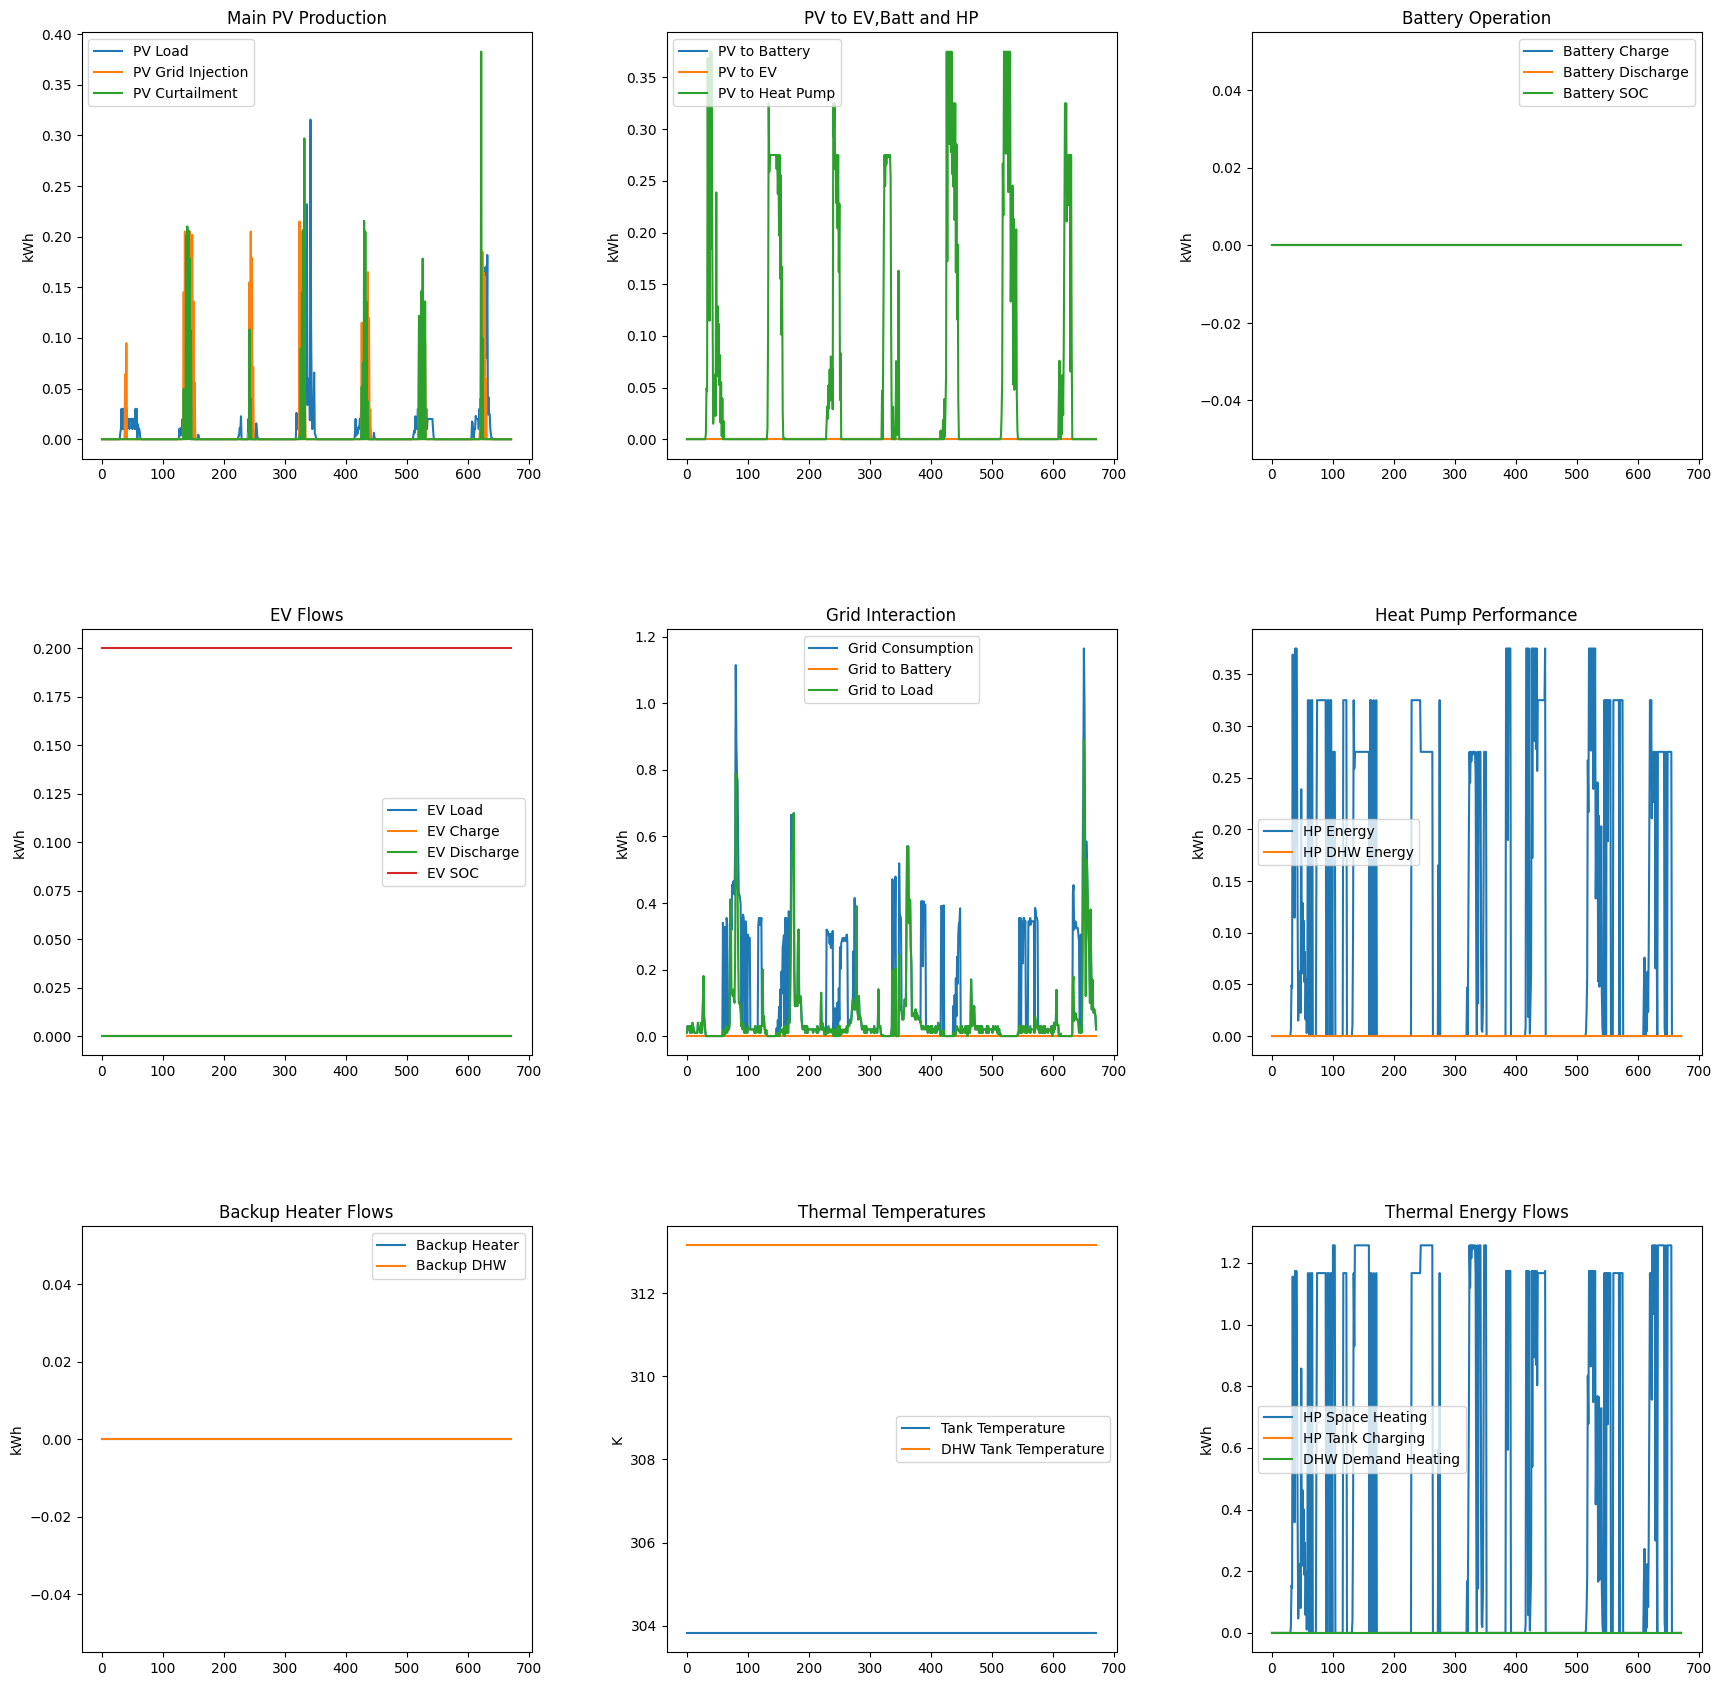

In [7]:
plot_df(df)

In [8]:
df=pd.read_csv('../Output/df_Low119187_284984_NMC_0100_7_0100_SFH100.csv')

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_32060\334176635.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


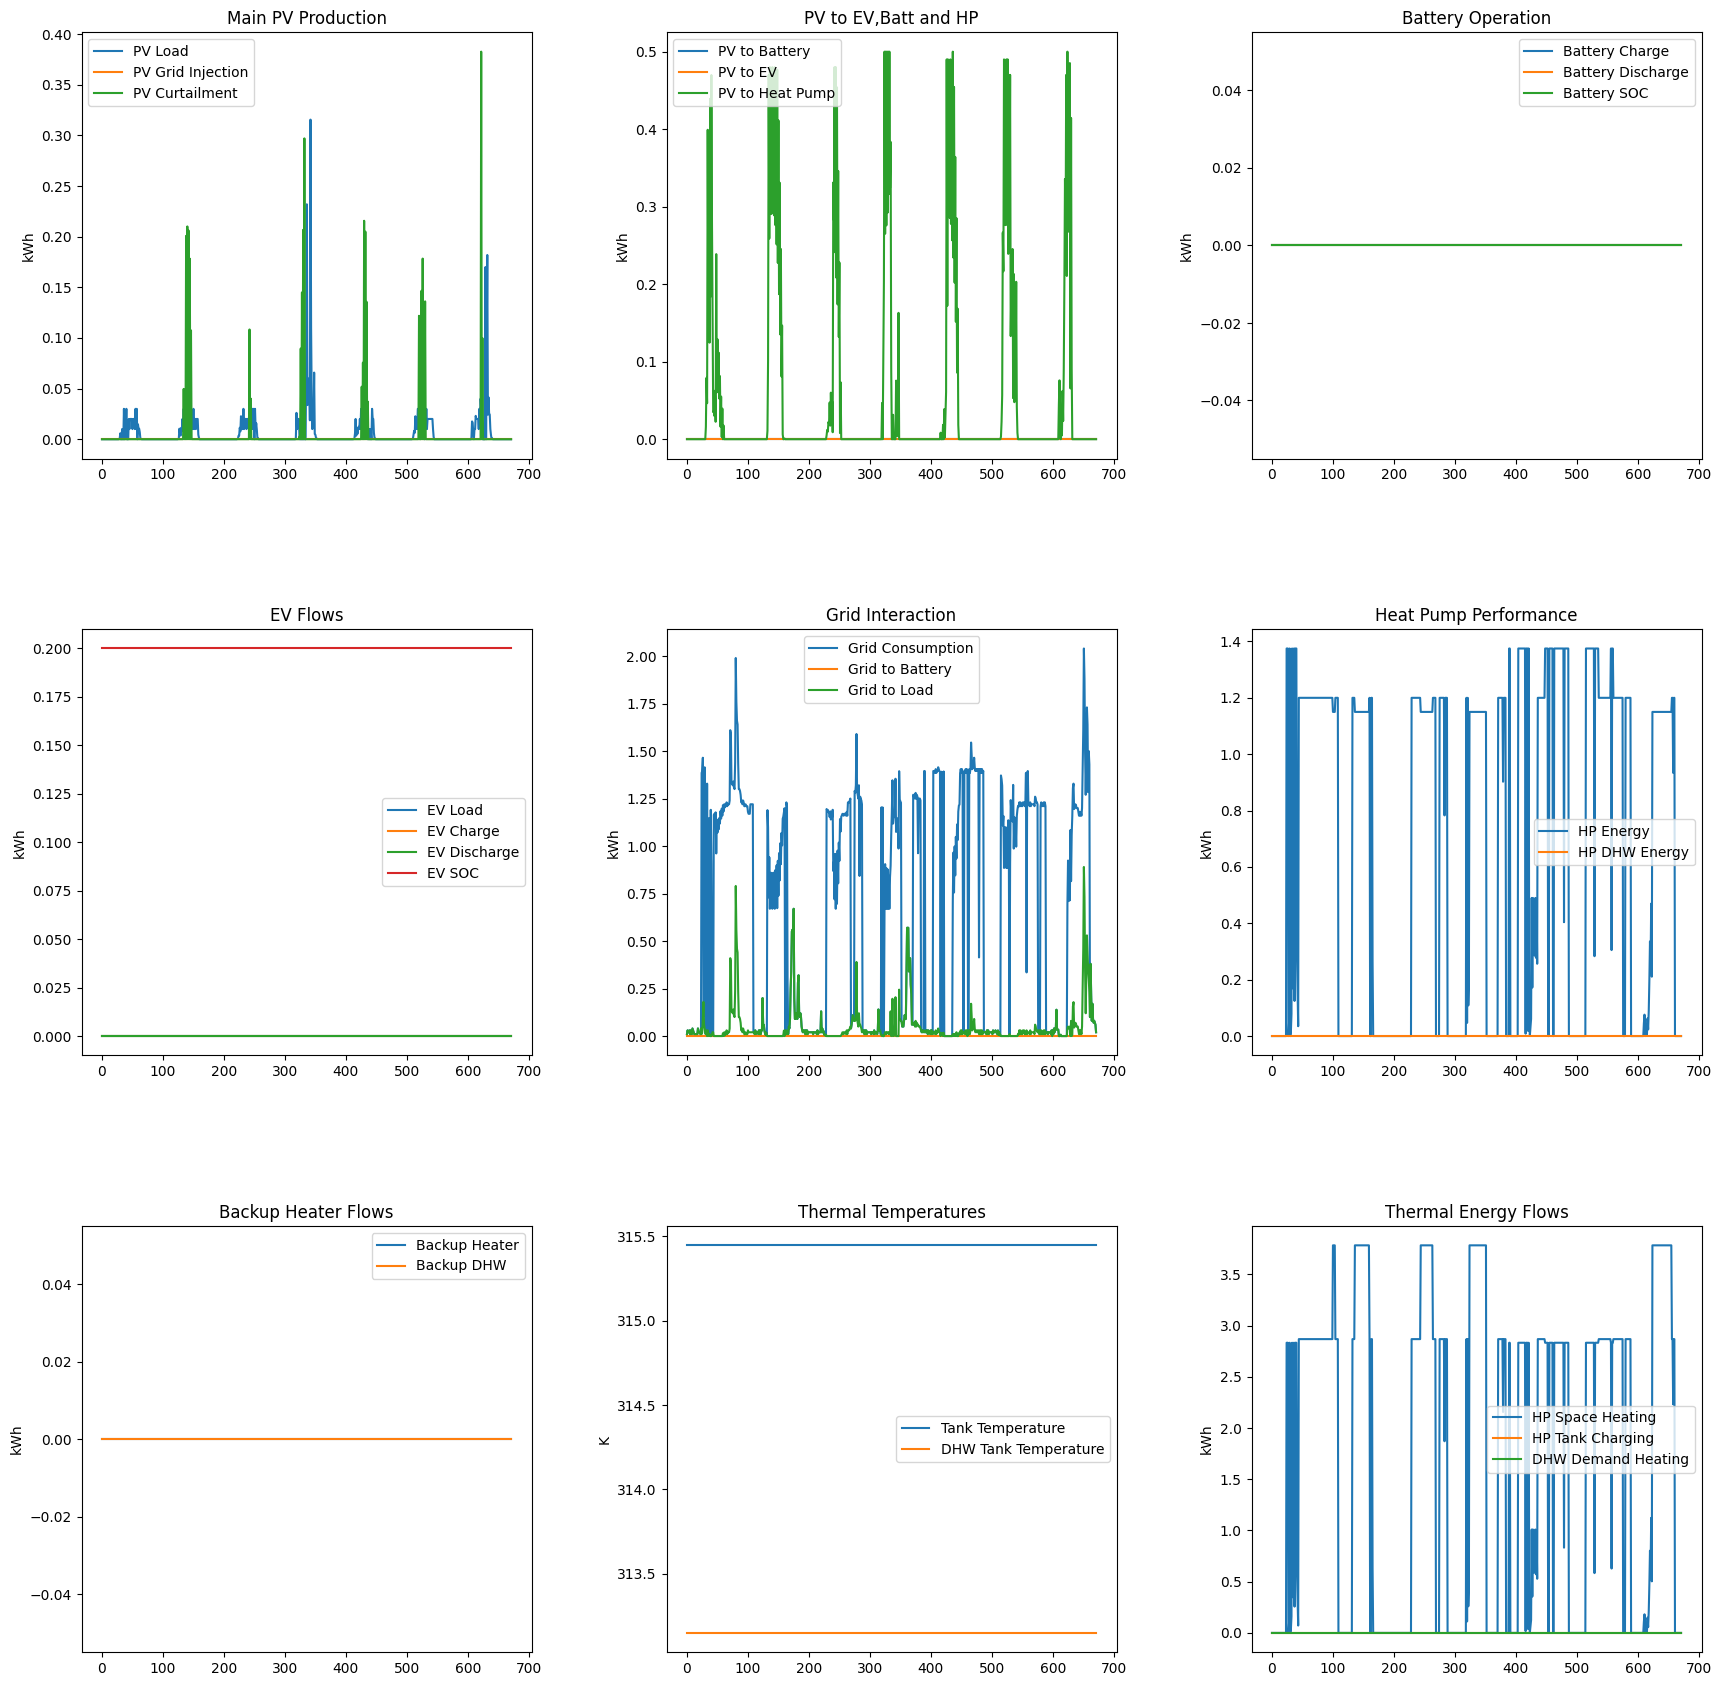

In [9]:
plot_df(df)

In [16]:
df=pd.read_csv('../Output/df_Low426842_415443_NMC_0100_7_0101_SFH100.csv')

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_32060\334176635.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


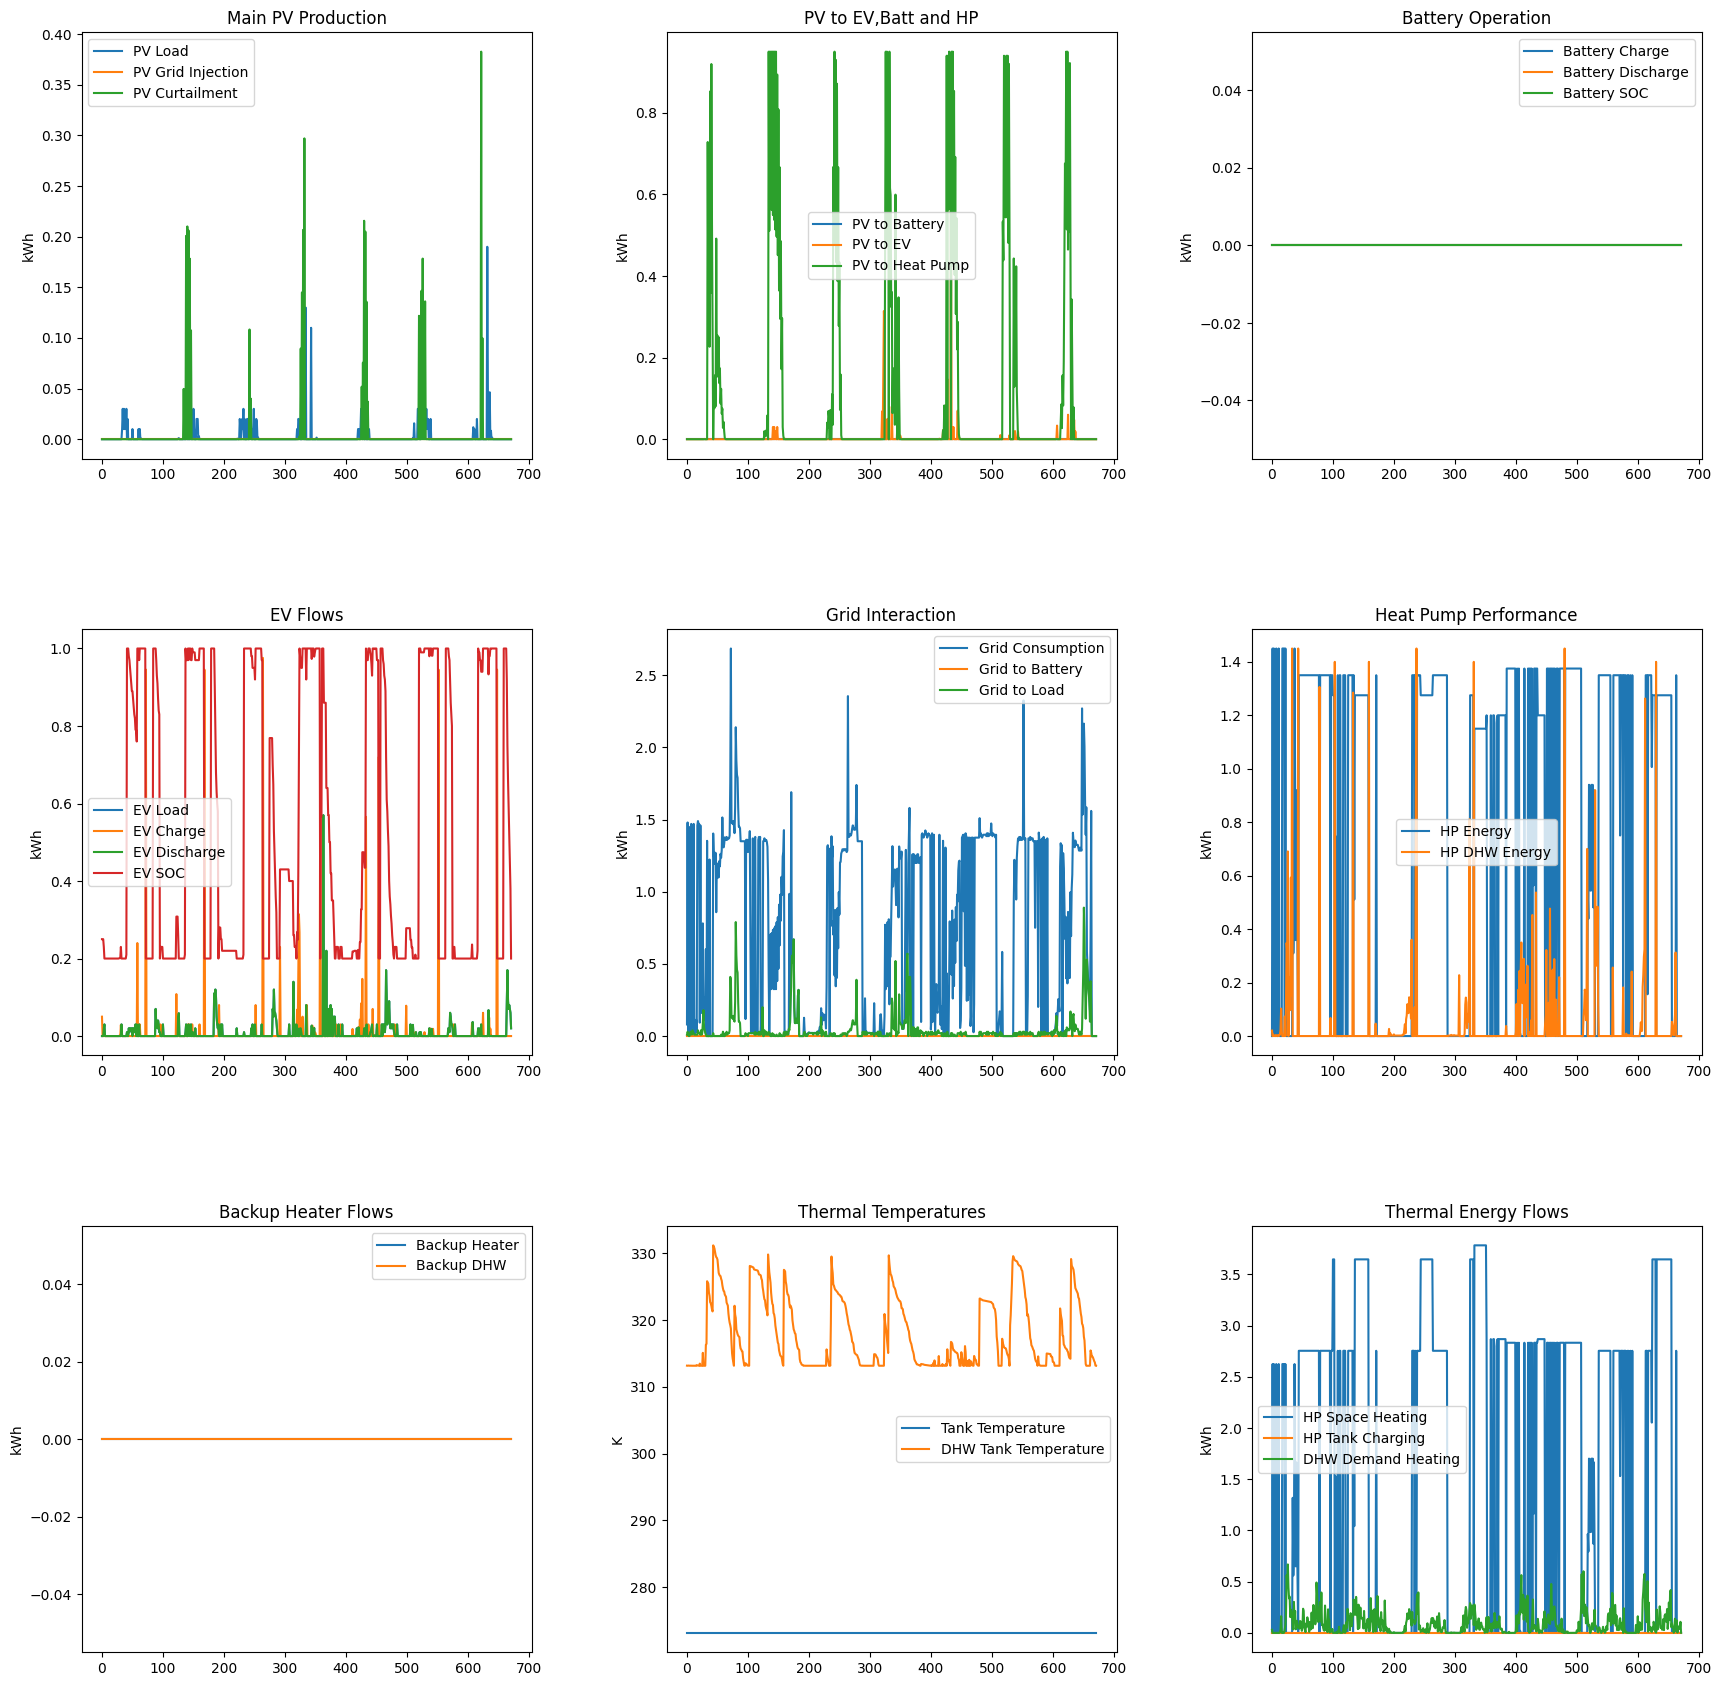

In [17]:
plot_df(df)